# "Distributed Gradient Descent with Spark"
> "Optimization for big data."
- toc: true
- branch: master
- badges: true
- comments: true
- categories: [data science]
- hide: false
- search_exclude: false

This post will cover how to implement the batch gradient descent algorithm in a distributed fashion, using [PySpark](https://spark.apache.org/docs/latest/api/python/pyspark.html). There are many [variations of gradient descent](https://ruder.io/optimizing-gradient-descent/) out there, but this post will cover "vanilla" gradient descent, and focus primarily on the implementational details in Spark.

Gradient descent is optimization algorithm. Most typically, you'll see it associated with machine learning, which is the context we'll be working in throughout this post, but it's important to acknowledge that it's fully able to stand up on it's own. The algorithm can equivalently be used to optimize a neural network or find the minimum of $f(x)=x^3-2x^2+2$. Generally speaking, the gradient descent algorithm tries to approximate what inputs correspond to the minimum value of a function. It makes no guarantees - meaning that the approximation may or may not be the true minimum. Mechanically, the algorithm exploits the property that the [gradient points in the direction of steepest ascent](https://math.stackexchange.com/questions/223252/why-is-gradient-the-direction-of-steepest-ascent). I will not be getting too deep into the weeds with the math, but if you're interested, here is a [high-level](https://hackernoon.com/life-is-gradient-descent-880c60ac1be8) and [low-level](https://mathworld.wolfram.com/MethodofSteepestDescent.html) overview.

# Gradient Descent with NumPy

Before jumping directly into a distributed setting, it's helpful to start with a small example. First, we'll get our head around a vectorized implementation of gradient descent for linear regression, using NumPy.

Linear regression can be used to make predictions about a continuous target variable, using a set of predictor variables. We'll refer to those predictions as $\hat{y}$, where

$$\hat{y} = \underbrace{X}_{m\times n}\cdot \underbrace{w}_{n\times 1}$$

and $X$ is a matrix of $m$ observations, each observation composed of $n$ predictor variables. Additionally, $w$ is a vector of $n$ _weights_ (aka coefficients). Since our focus in on the algorithm, we'll use [`sklearn.datasets.make_regression()`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_regression.html) to generate a dataset, $X$, that is amenable to linear regression.

In [13]:
#collapse
import numpy as np
import matplotlib
matplotlib.rcParams['text.usetex'] = True
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
from sklearn.metrics import r2_score

In [14]:
data_kwargs = {"n_samples":100, "n_features":2,
               "noise":3, "coef":True, 
               "random_state":742}
X, y, coef = make_regression(**data_kwargs)
w = np.zeros(X.shape[1]).reshape(-1,1)
print(f"X is of type: {type(X)}, and of dimension: {X.shape}.")
print(f"w is of type: {type(w)}, and of dimension: {w.shape}.")
print(f"y is of type: {type(y)}, and of dimension: {y.reshape(-1,1).shape}.")

X is of type: <class 'numpy.ndarray'>, and of dimension: (100, 2).
w is of type: <class 'numpy.ndarray'>, and of dimension: (2, 1).
y is of type: <class 'numpy.ndarray'>, and of dimension: (100, 1).


{% include info.html text="Note: linear regression often has an intercept term in addition to the weights. We choost to omit it in this post." %}

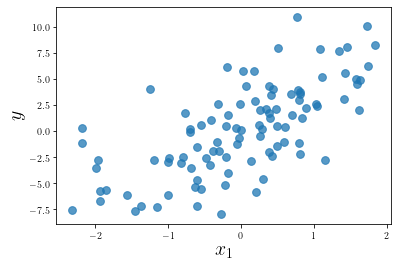

In [53]:
#collapse
plt.scatter(X[:, 0], y, alpha=0.75, s=60)
plt.xlabel(r"$x_1$", size=20)
plt.ylabel(r"$y$", size=20)
plt.show()

For our case, it's safe to instantiate $w$ with zeros. In machine learning, gradient descent iteratively updates the weights to minimize some loss function. The loss function's job is to tell us _how wrong_ our weights are at any given step of the algorithm. For linear regression, our loss function is the mean squared error of our predictions, $\hat{y}$, and the target variable, $y$.

$$
\begin{aligned}
MSE(y, \hat{y}) &= \frac{1}{m}\left(y - \hat{y}\right)^2\\
&= \frac{1}{m}\left(y - X\cdot w\right)^2
\end{aligned}
$$


The vectorized gradient of MSE is (for a full derivation, see page 9 of [this pdf](https://github.com/parrt/msds621/blob/master/projects/linreg/linreg.pdf)),

$$\frac{\partial\ \text{MSE}}{\partial\ w} = -\left(\frac{2}{m}\right)X^T\cdot \left(y - X\cdot w\right)$$


*You should note: in the equations about, we are doing element-wise subtraction between vectors $y$ and $\hat{y}$, as well as a dot product between a $X$ and $w$.*

In code, the MSE and its gradient can be implemented like this,

In [6]:
def mse(X, y, w):
    return ((y - np.dot(X, w))**2).mean()

def mse_gradient(X, y, w):
    residual = y - np.dot(X, w)
    return (-2/X.shape[0]) * np.dot(X.T, residual)

At this point, we have all the pieces we need to put the gradient descent algorithm to use in finding the optimal $w$. In our implementation, we will make `n_iters` updates to `w`, each time re-assigning it with the following rule, 

$$w \leftarrow w - \alpha \ \left(\frac{\partial\ \text{MSE}}{\partial\ w}\right)$$

where $\alpha$ is a small constant referred to as the [learning rate](https://heartbeat.fritz.ai/introduction-to-learning-rates-in-machine-learning-6ed685c16506).

In [40]:
# leaning towards verbosity when possible to make code as clear as possible
def gradient_descent(X, y, learning_rate=0.1, n_iters=100):
    w = np.zeros(X.shape[1])
    losses = []
    for i in range(n_iters):
        w_gradient = mse_gradient(X, y, w)
        w = w - learning_rate*w_gradient
        loss = mse(X, y, w)
        losses.append(loss)
    
    return w, losses

There are a couple ways to verify that our algorithm is working correctly. The simplest way is to plot our predictions against the raw data.

In [46]:
# change `n_features` for illustrative example
data_kwargs.update({"n_features":1})
X, y, coef = make_regression(**data_kwargs)
w, losses = gradient_descent(X, y)

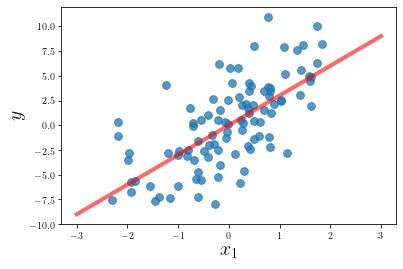

Our gradient descent converged on w = 3.0048.
Scikit-Learn used w = 3.0549 to generate the data.


In [60]:
#collapse
plt.scatter(X[:, 0], y, alpha=0.75, s=60)
xx = np.linspace(-3, 3, 100).reshape(-1, 1)
yy = np.dot(xx, w)
plt.plot(xx, yy, c='r', lw=4, alpha=0.6)
plt.xlabel(r"$x_1$", size=20)
plt.ylabel(r"$y$", size=20)
plt.show()

print(f"Our gradient descent converged on w = {round(w.item(), 4)}.")
print(f"Scikit-Learn used w = {round(coef.item(), 4)} to generate the data.")

It can be a bit trickier to visualize our predictions with multi-dimensional data, so we'll resort to evaluating $R^2$ scores, plotting the losses, and directly comparing the weights to Scikit-Learn's.

---

# Distributed gradient descent with PySpark

*Many of the ideas presented here come from [this lecture](https://stanford.edu/~rezab/classes/cme323/S17/notes/lecture16/cme323_lec16.pdf), given in the Spring of 2017 by Reza Zadeh, from Stanford.*

A single CPU is enough to crunch all of the matrix computation in the simple example above, but in the real-world setting, it is not uncommon to deal with datasets that are quite a few orders of magnitude larger. In these scenarios, it becomes advantageous to use multiple computers, in unison, to carry out our computations. For this, Spark is the perfect tool. While Spark's [MLlib](https://spark.apache.org/mllib/) has many off-the self algorithms, implementing our own gradient descent is a fantastic exercise to broaden our understanding of Spark and distributed computing.

In [61]:
import pyspark
sc = pyspark.SparkContext().getOrCreate()

Let's simulate some (slightly) big(ger) data by bumping up `n_samples` to 1 million and `n_features` to 50.

In [83]:
data_kwargs.update({"n_samples":100, "n_features":1})
X, y, coef = make_regression(**data_kwargs)
data = np.hstack([X, y.reshape(-1,1)]).tolist()

In [84]:
rdd = sc.parallelize(data)

In [85]:
# rdd.take(5)

In [86]:
# perhaps put something in there so that it returns the squared error as well? So that we can track the losses?

def mse_gradient(rdd_row, weights):
    x = rdd_row[:-1]
    y = rdd_row[-1]
    residual = y - sum(x_j*w for x_j, w in zip(x, weights)) # dot product
    weights_gradient = [-x_j*residual for x_j in x]
    return weights_gradient
# notice we lost the constant on the front - this is okay because it won't affect gradient, only magnitude

# cumulative sum of gradients
def cum_sum_gradients(row, next_row):
    return [x+y for x, y in zip(row, next_row)]

In [87]:
# using verbose variable names, but trying to be as explicit as possible
def distributed_gradient_descent(rdd, learning_rate=0.1, n_iters=100):
    weights = np.zeros(len(rdd.first())-1).tolist() # -1 because the last column is y
    m = rdd.count()
    for i in range(n_iters):
        weights_gradient = rdd.map(lambda row: mse_gradient(row, weights))\
                              .reduce(lambda row, next_row: cum_sum_gradients(row, next_row))
        weights_gradient = [learning_rate*(w/m) for w in weights_gradient]
        weights = [w - w_grad for w, w_grad in zip(weights, weights_gradient)]
    
    return weights

In [88]:
start = time.time()
w = distributed_gradient_descent(rdd, n_iters=50)
print(time.time() - start)

KeyboardInterrupt: 

In [ ]:
w

In [ ]:
coef

In [89]:
sc.stop()